In [7]:
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
import networkx as nx
import pandas as pd
import numpy as np
sys.path.insert(0, Path.cwd().absolute())

BASE_DIR = (Path.cwd()).parent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from network_analysis.flow_assignment import FlowAssignment
from geoprocessing.faf_zone_network import FafZoneNetwork, link_weights
from network_analysis.mc_flow_assignment import sample_flows
import geopandas as gpd

In [48]:
MODE = 'compare' # normal, simple, monte_carlo, compare

SIMPLE_NET = False
MONTE_CARLO = False
if MODE == 'simple':
  SIMPLE_NET = (421, 423, 341, 342 )
if MODE == 'monte_carlo':
  MONTE_CARLO = True

MC_ITER_N = 500
NORMAL_DIST = True

COLUMN = 'thousand tons in 2020'
COMPARE_COLUMN = 'thousand tons in 2018'
  

In [49]:
naRailNodesDf = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Nodes")
naRailLinesDf = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Lines")
fafZonesDf = gpd.read_file( BASE_DIR / "inputs/2017_CFS_Metro_Areas_with_FAF").to_crs(4326)
fzn = FafZoneNetwork(naRailNodesDf, naRailLinesDf, fafZonesDf).setInputDfColType()
if SIMPLE_NET:
  fzn.fafZonesDf = fzn.fafZonesDf.loc[fzn.fafZonesDf.FAF_Zone.isin(SIMPLE_NET)]
  faf_flows = pd.DataFrame([
    [ 421, 423, 10],
    [421,341, 77],
    [342, 423, 96]
  ], columns=['dms_orig', 'dms_dest', COLUMN])
  display(SIMPLE_NET)
  display(faf_flows)
else:
  faf_flows = pd.read_csv(Path.cwd().parent / 'inputs/faf_freight_flow.csv' )
  display(faf_flows)
fzn.network_weight_fn = link_weights
railnet = fzn.createNetwork()

,dms_orig,dms_dest,sctg2,dms_mode,thousand tons in 2017,thousand tons in 2018,thousand tons in 2019,thousand tons in 2020,thousand tons in 2021,thousand tons in 2022,...,thousand tons in 2035_high,thousand tons in 2040,thousand tons in 2040_low,thousand tons in 2040_high,thousand tons in 2045,thousand tons in 2045_low,thousand tons in 2045_high,thousand tons in 2050,thousand tons in 2050_low,thousand tons in 2050_high
0,11,11,12,2,740.0959,753.5056,851.0898,839.2379,1021.9542,920.2180,...,980.5118,957.7141,895.4462,1006.7947,1036.7981,935.0777,1073.2262,1121.3557,973.4778,1148.8061
1,11,11,19,2,42.0036,46.2087,44.6257,43.4698,43.6799,46.1044,...,21.2153,20.0290,19.1487,20.4295,20.4124,19.1490,20.8206,19.8552,18.2867,20.2523
2,11,11,23,2,12.5502,12.6966,11.8313,11.0730,11.5673,11.7494,...,21.6048,24.6074,24.1112,25.0996,28.1451,27.2151,28.7080,30.9752,29.5641,31.5947
3,11,11,27,2,0.0574,0.0587,0.0563,0.0563,0.0551,0.0536,...,0.0423,0.0395,0.0382,0.0408,0.0395,0.0376,0.0414,0.0390,0.0367,0.0416
4,11,11,28,2,0.0082,0.0083,0.0081,0.0082,0.0085,0.0082,...,0.0129,0.0136,0.0133,0.0144,0.0149,0.0144,0.0161,0.0166,0.0158,0.0182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131010,560,560,17,2,10.4320,10.5149,10.5263,9.0030,10.1474,10.7672,...,10.6214,8.4527,8.3682,10.4027,7.9643,7.8847,10.0297,7.4917,7.4168,9.6411
131011,560,560,19,2,1730.1339,1915.9901,1846.9680,1764.0476,1225.8048,1131.0459,...,2815.3581,2533.2344,2507.9021,3240.5367,2781.5166,2753.7014,3652.9657,3066.9209,3002.4153,4125.9913
131012,560,560,20,2,283.0778,280.2049,267.0370,252.2117,268.3004,247.1620,...,800.1731,650.6673,644.1606,1042.2652,718.8437,711.6553,1242.6647,835.3533,826.9998,1537.8987
131013,560,560,22,2,5.7048,5.6248,6.3645,6.2680,6.7687,4.8812,...,14.5586,10.9627,10.0108,17.7710,11.6026,9.9985,19.7361,13.2972,10.6780,23.5662


In [50]:
faf_flows.columns

Index(['dms_orig', 'dms_dest', 'sctg2', 'dms_mode', 'thousand tons in 2017',
       'thousand tons in 2018', 'thousand tons in 2019',
       'thousand tons in 2020', 'thousand tons in 2021',
       'thousand tons in 2022', 'thousand tons in 2023',
       'thousand tons in 2025', 'thousand tons in 2025_low',
       'thousand tons in 2025_high', 'thousand tons in 2030',
       'thousand tons in 2030_low', 'thousand tons in 2030_high',
       'thousand tons in 2035', 'thousand tons in 2035_low',
       'thousand tons in 2035_high', 'thousand tons in 2040',
       'thousand tons in 2040_low', 'thousand tons in 2040_high',
       'thousand tons in 2045', 'thousand tons in 2045_low',
       'thousand tons in 2045_high', 'thousand tons in 2050',
       'thousand tons in 2050_low', 'thousand tons in 2050_high'],
      dtype='object')

In [51]:
fa = FlowAssignment(railnet)

railnet_flows = fa.run(faf_flows, SUM_COLUMN=COLUMN) # For comparison, if Monte Carlo mode

if MODE == 'compare':
  compare_flows = fa.run(faf_flows, SUM_COLUMN=COMPARE_COLUMN)
  fzn.apply_flows((railnet_flows - compare_flows).to_dict())

if MODE == 'normal':
  fzn.apply_flows(railnet_flows.to_dict())

if MONTE_CARLO:
  monte_railnet_flows = []
  monte_inputs = []
  for i in range(MC_ITER_N):
    iteration_inputs = sample_flows(faf_flows, COLUMN, distribution='normal' if NORMAL_DIST else 'triangular')
    monte_inputs.append(iteration_inputs)
    faf_flows['input_flows'] = iteration_inputs
    iteration_flow = fa.run(faf_flows, SUM_COLUMN='input_flows')
    monte_railnet_flows.append(iteration_flow)
  monte_railnet_flows = pd.concat(monte_railnet_flows, axis=1)
  monte_railnet_flows.columns=range(MC_ITER_N)
  fzn.fafZoneLinksDf['flows'] = monte_railnet_flows.mean(axis=1)
  fzn.fafZoneLinksDf['flow_covs'] = monte_railnet_flows.std(axis=1) / monte_railnet_flows.mean(axis=1)
  railnet_flows.index = railnet_flows.index.set_names({'seg_start':'FAF_Zone_fr', 'seg_end':'FAF_Zone_to'})
  fzn.fafZoneLinksDf['flow_df'] = (fzn.fafZoneLinksDf['flows'] - railnet_flows).abs()
  fzn.fafZoneLinksDf['flow_df_percent'] = fzn.fafZoneLinksDf['flow_df'] / railnet_flows

,FAF_Zone_1_fr,FAF_Zone_1_to,flowr
0,"Houston-The Woodlands, TX CFS Area",Remainder of Texas,10899.0
1,"Corpus Christi-Kingsville-Alice, TX CFS Area",Remainder of Texas,7731.0
2,"Lake Charles-Jennings, LA CFS Area",Remainder of Louisiana,6289.0
3,"Dallas-Fort Worth, TX-OK CFS Area (TX Part)",Remainder of Texas,2240.0
4,"Minneapolis-St. Paul, MN-WI CFS Area (MN Part)",Remainder of Wisconsin\r,1806.0
5,Remainder of Oklahoma,Remainder of Texas,1248.0
6,"Laredo, TX CFS Area",Remainder of Texas,1235.0
7,"Lake Charles-Jennings, LA CFS Area","Beaumont-Port Arthur, TX CFS Area",1216.0
8,"Cleveland-Akron-Canton, OH CFS Area",Remainder of Ohio,1151.0
9,"New Orleans-Metairie-Hammond, LA-MS CFS Area ...",Remainder of Louisiana,1150.0


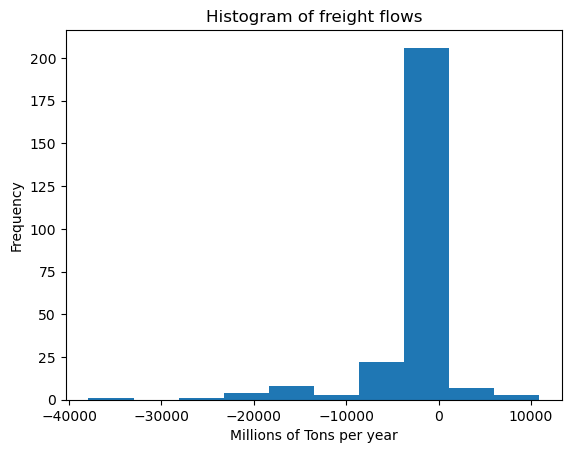

In [52]:
import matplotlib.pyplot as plt

import folium
import branca.colormap as cm
from IPython.display import display


min_lat=24.7433195
max_lat=49.3457868
min_lon=-124.7844079
max_lon=-66.9513812


m = folium.Map(
  max_bounds=True,
  location=[42, -95],
  zoom_start=4,
  min_zoom=4,
  tiles='OpenStreetMap',
  # max_lat=max_lat,
  # min_lon=min_lon,
  # max_lon=max_lon,
  # min_lat=min_lat
)

m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
wmax = fzn.fafZoneLinksDf['flows'].max()
wmin = fzn.fafZoneLinksDf['flows'].min()

def select_flows(feature):
  return feature['properties']['flows']

def norm_w(feature):
  return (select_flows(feature) - wmin)/(wmax-wmin)

def norm_abs_fn(feature):
  value = select_flows(feature)
  return value/(wmax if value > 0 else -wmin)

lineWeightMax = 4
lineWeightMin = 0.75

if True:
  zoneDf = fzn.fafZonesDf.copy()
  zoneDf.geometry = zoneDf.geometry.simplify(.15)
  zoneDf[['FAF_Zone_1', 'geometry']].explore(
    m=m,
    column='FAF_Zone_1',
    cmap='Greens',
    legend=False,
    style_kwds={'opacity':.1}
  )

if False: 
  from folium import DivIcon
  for i, r in fzn.fafZoneLinksDf.iterrows():
    center = r.geometry.centroid
    folium.map.Marker(
      [center.y, center.x],
      icon=DivIcon(
          icon_size=(20,150),
          icon_anchor=(0,0),
          html='<div style="font-size: 12px">%s</div>' % round(r.flows,4),
        )
    ).add_to(m)


  for i, r in fzn.fafZoneNodesDf.iterrows():
    center = r.geometry.centroid
    folium.map.Marker(
      [center.y, center.x],
      icon=DivIcon(
          icon_size=(20,150),
          icon_anchor=(0,0),
          html='<div style="font-size: 16px; font-weight: bold">%s</div>' % int(i),
        )
    ).add_to(m)


fzn.fafZoneLinksDf[['FAF_Zone_1_fr', 'FAF_Zone_1_to', 'flows', 'geometry']].explore(
  m=m,
  column='flows',
  style_kwds={
    'style_function': lambda feature: {
      'color': cm.linear.plasma(norm_w(feature)),
      'weight': norm_w(feature) * (lineWeightMax - lineWeightMin) + lineWeightMin
    } if MODE != 'compare' else {
      'color': cm.linear.RdYlGn_11(norm_abs_fn(feature) + .5),
      'weight': abs(norm_abs_fn(feature)) * 3 + 1,
      # 'yooo': print(abs(norm_abs_fn(feature)) if select_flows(feature) < 0 else False)
    }
  }
)

fzn.fafZoneNodesDf[['FAF_Zone_1', 'geometry']].explore(
  m=m,
  color='black'
)
display(m)
if MONTE_CARLO:
  fzn.fafZoneLinksDf['flow_df%'] = (fzn.fafZoneLinksDf['flow_df_percent'] * 100).round(2)
fzn.fafZoneLinksDf['flowr'] = fzn.fafZoneLinksDf['flows'].round()

display(fzn.fafZoneLinksDf.sort_values('flows', axis=0, ascending=False).reset_index()[
  ['FAF_Zone_1_fr', 'FAF_Zone_1_to', 'flowr'] + (['flow_df%', 'flow_covs', 'flow_df', ] if MONTE_CARLO else [])
].head(10))
fzn.fafZoneLinksDf['flows'].plot(
  kind='hist',
  title='Histogram of freight flows',
  xlabel='Millions of Tons per year'
)
plt.show()

if MONTE_CARLO:
  from matplotlib.ticker import PercentFormatter

  diff_percents = monte_railnet_flows.sub(railnet_flows, axis=0).abs().div(railnet_flows, axis=0).mul(100, axis=0)
  plot = diff_percents.T.expanding().mean().abs().mean(axis=1).plot(
    title='Monte Carlo Simulation Convergence',
    xlabel='Iterations',
    ylabel='Precent Error'
  )
  plot.yaxis.set_major_formatter(PercentFormatter())
  plt.show()
  avg_diff_percents = diff_percents.mean(axis=1)
  fzn.fafZoneLinksDf.loc[~np.isfinite(fzn.fafZoneLinksDf.flow_df_percent), 'flow_df_percent'] = 0
  plot = avg_diff_percents.plot(
    kind='hist',
    title='Histogram of flow errors in percent',
    xlabel='Percent Error'
  )
  mean_error = avg_diff_percents.mean()
  plt.axvline(mean_error, color='k')
  plot.xaxis.set_major_formatter(PercentFormatter())
  
  min_ylim, max_ylim = plt.ylim()
  plt.text(mean_error * 1.1, max_ylim*0.9, 'Mean: {:.4f}%'.format(mean_error))
  plt.show()